In [274]:
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

from mcmc import metropolis_hastings

# seaborn settings
sns.set_theme()
sns.set_context("poster", font_scale=1.4)

%matplotlib inline

In [275]:
def gaussian_proposal(x, sigma):
    return np.random.normal(x, sigma, (len(x), ))

def prior(x):
    #x[0] = mu, x[1]=sigma (new or current)
    #returns 1 for all valid values of sigma. Log(1) =0, so it does not affect the summation.
    #returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    #It makes the new sigma infinitely unlikely.
    if(x[1] <=0):
        return 0
    return 1

def log_likelihood(x, data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi))-((data-x[0])**2) / (2*x[1]**2))

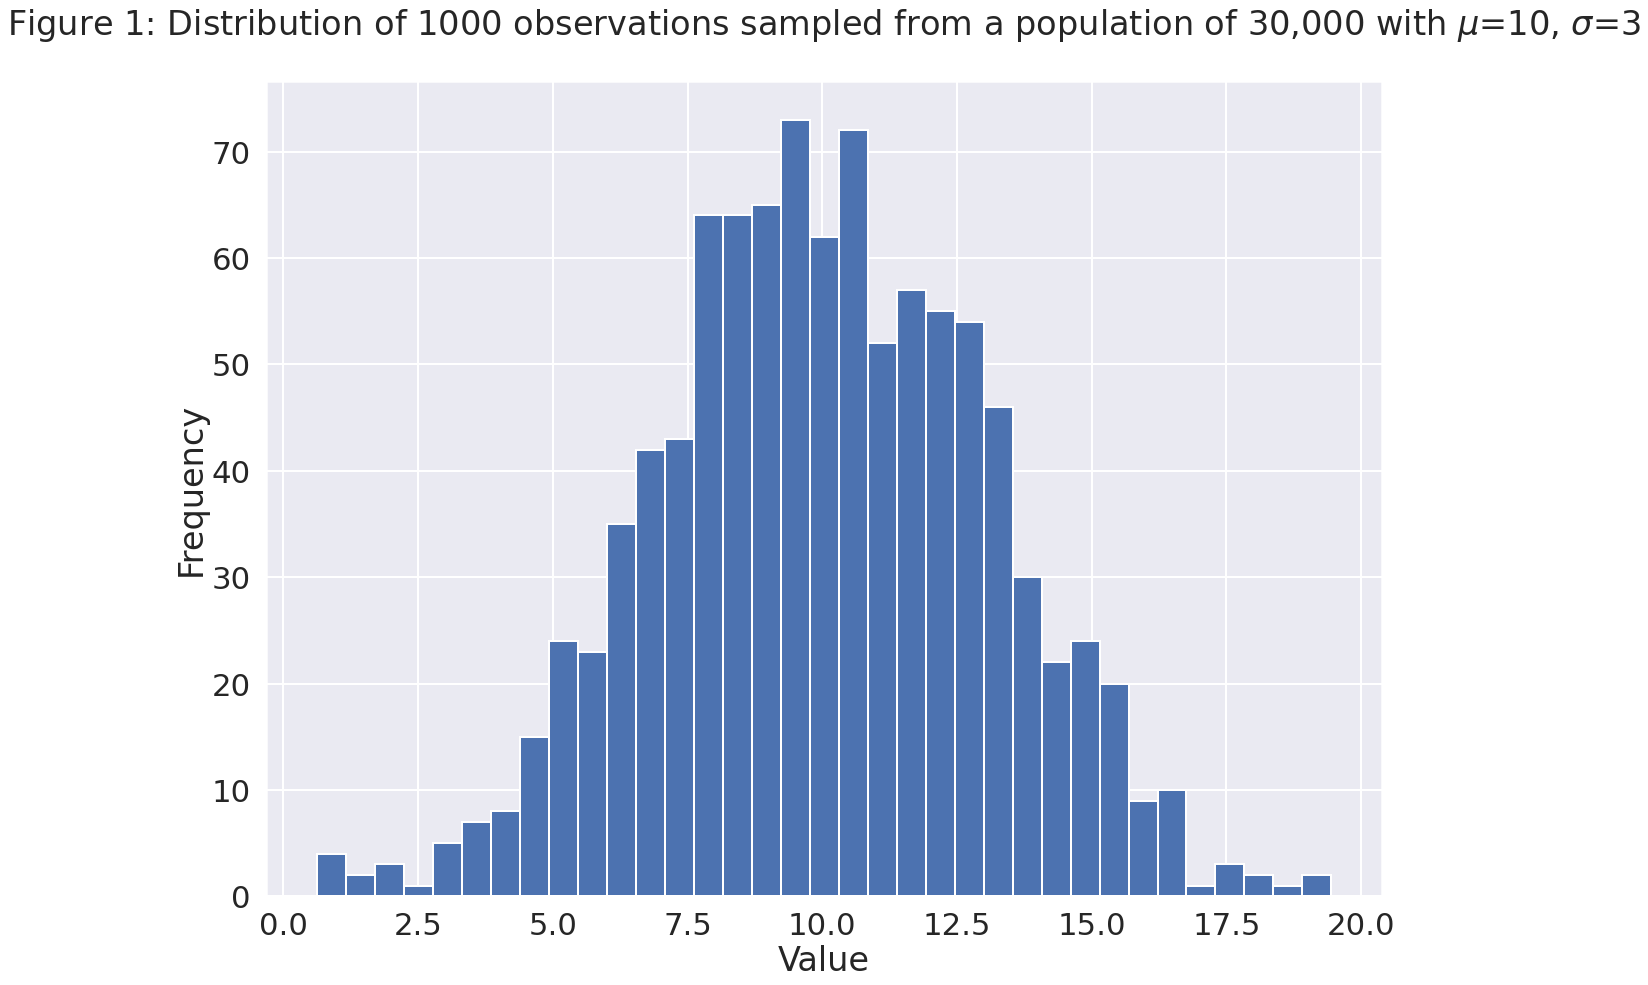

In [276]:
# Form a population of 30,000 individual, with average=10 and scale=3
population = np.random.normal(10,3,30000)
# Assume we are only able to observe 1,000 of these individuals.
observation = population[np.random.randint(0, 30000, 1000)]

mu_obs=observation.mean()

fig, ax = plt.subplots(figsize=(20,15))
ax.hist(observation,bins=35)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of 1000 observations sampled from a population of 30,000 with $\mu$=10, $\sigma$=3\n")
plt.show()

In [279]:
def metropolis_hastings(x_init, proposal, prior, log_likelihood, data, 
                        proposal_kwargs={}, samples=10000, burn_in=0.0):
    """ Algorithm 27.3 Metropolis-Hastings MCMC sampling from
    David Barber's Bayesian Reasoning and Machine Learning.
    
    Modified to use log of acceptance ratio for numerical stability.

    :param x_init: numpy.ndarray or int, float
        The initial state.
    :param proposal: callable(x)
        The proposal distribution function.
    :param prior: callable(x)
        The prior distribution function.
    :parma log_likelihood: callable(x, data)
        The likelihood function for x given the data. 
        Should be the log of the likelihood for numerical 
        stability.
    :param data: array_like
        Data used to determine the likelihood of parameters.
    :param proposal_kwargs: dict
        Keyword arguments for proposal function.
    :param samples: int
        The number of samples to take. Default is 10000.
    :param burn_in: float
        The percentage of samples from the beginning to 
        remove. Must be a float between 0 and 1. 
        0 is equivalent to removing no samples and 1 is equivalent
        to removing them all.
    :return: numpy.ndarray
        The samples taken.
        If x_init is a int or float a 1 dimensional array will be returned.
        If x_init is a numpy.ndarray or list a 2 dimensional array will be
            returned. The fist dimension contains the samples, and the
            second each element of all the sampled states.
    """
    
    rejected = []
    accepted = []
    
    if samples < 1:
        
        raise Exception('samples must be greater than 0')
        
    if burn_in < 0 or burn_in > 1:
        
        raise Exception('burn_in must be between 0 and 1')
    
    x = x_init  # set x0

    for l in range(1, samples):

        x_cand = proposal(x, **proposal_kwargs)  # generate a random candidate state with the given the proposal function
        
        # compute acceptance ratio
        a = log_likelihood(x_cand, data) + np.log(prior(x_cand)) - log_likelihood(x, data) - np.log(prior(x))

        if a >= 0:  # 0 instead of 1 because we took the log of the acceptance ratio

            x = x_cand
            accepted.append(x_cand)

        else:

            u = np.random.uniform(0, 1)  # draw a random value u uniformly from the unit interval [0, 1]

            if u < np.exp(a):

                x = x_cand
                accepted.append(x_cand)

            else:

                rejected.append(x_cand)
    
    # convert to numpy and remove burn_in
    accepted = np.array(accepted)[int(samples * burn_in):]
    rejected = np.array(rejected)[int(samples * burn_in):]

    return accepted, rejected  # return samples

In [280]:
x_init = np.array([4, 0.1])
accepted, rejected = metropolis_hastings(x_init, gaussian_proposal, prior, log_likelihood, observation, 
                                         proposal_kwargs={'sigma': 0.5}, samples=10000, burn_in=0.0)

<ipython-input-275-da52a8fc8fe7>:16: RuntimeWarning: invalid value encountered in log
  return np.sum(-np.log(x[1] * np.sqrt(2* np.pi))-((data-x[0])**2) / (2*x[1]**2))
<ipython-input-279-912e2555b989>:55: RuntimeWarning: divide by zero encountered in log
  a = log_likelihood(x_cand, data) + np.log(prior(x_cand)) - log_likelihood(x, data) - np.log(prior(x))


In [281]:
accepted[-10:, 0], accepted[-10:, 1]

(array([10.01609349, 10.12788916, 10.16915942,  9.95578136, 10.11927541,
        10.14950027,  9.84016983, 10.00390913, 10.17648112,  9.97608987]),
 array([2.95222247, 3.17403425, 3.01317726, 3.13553983, 3.13700336,
        3.01223825, 3.06606458, 3.02851495, 3.07046049, 3.04524738]))

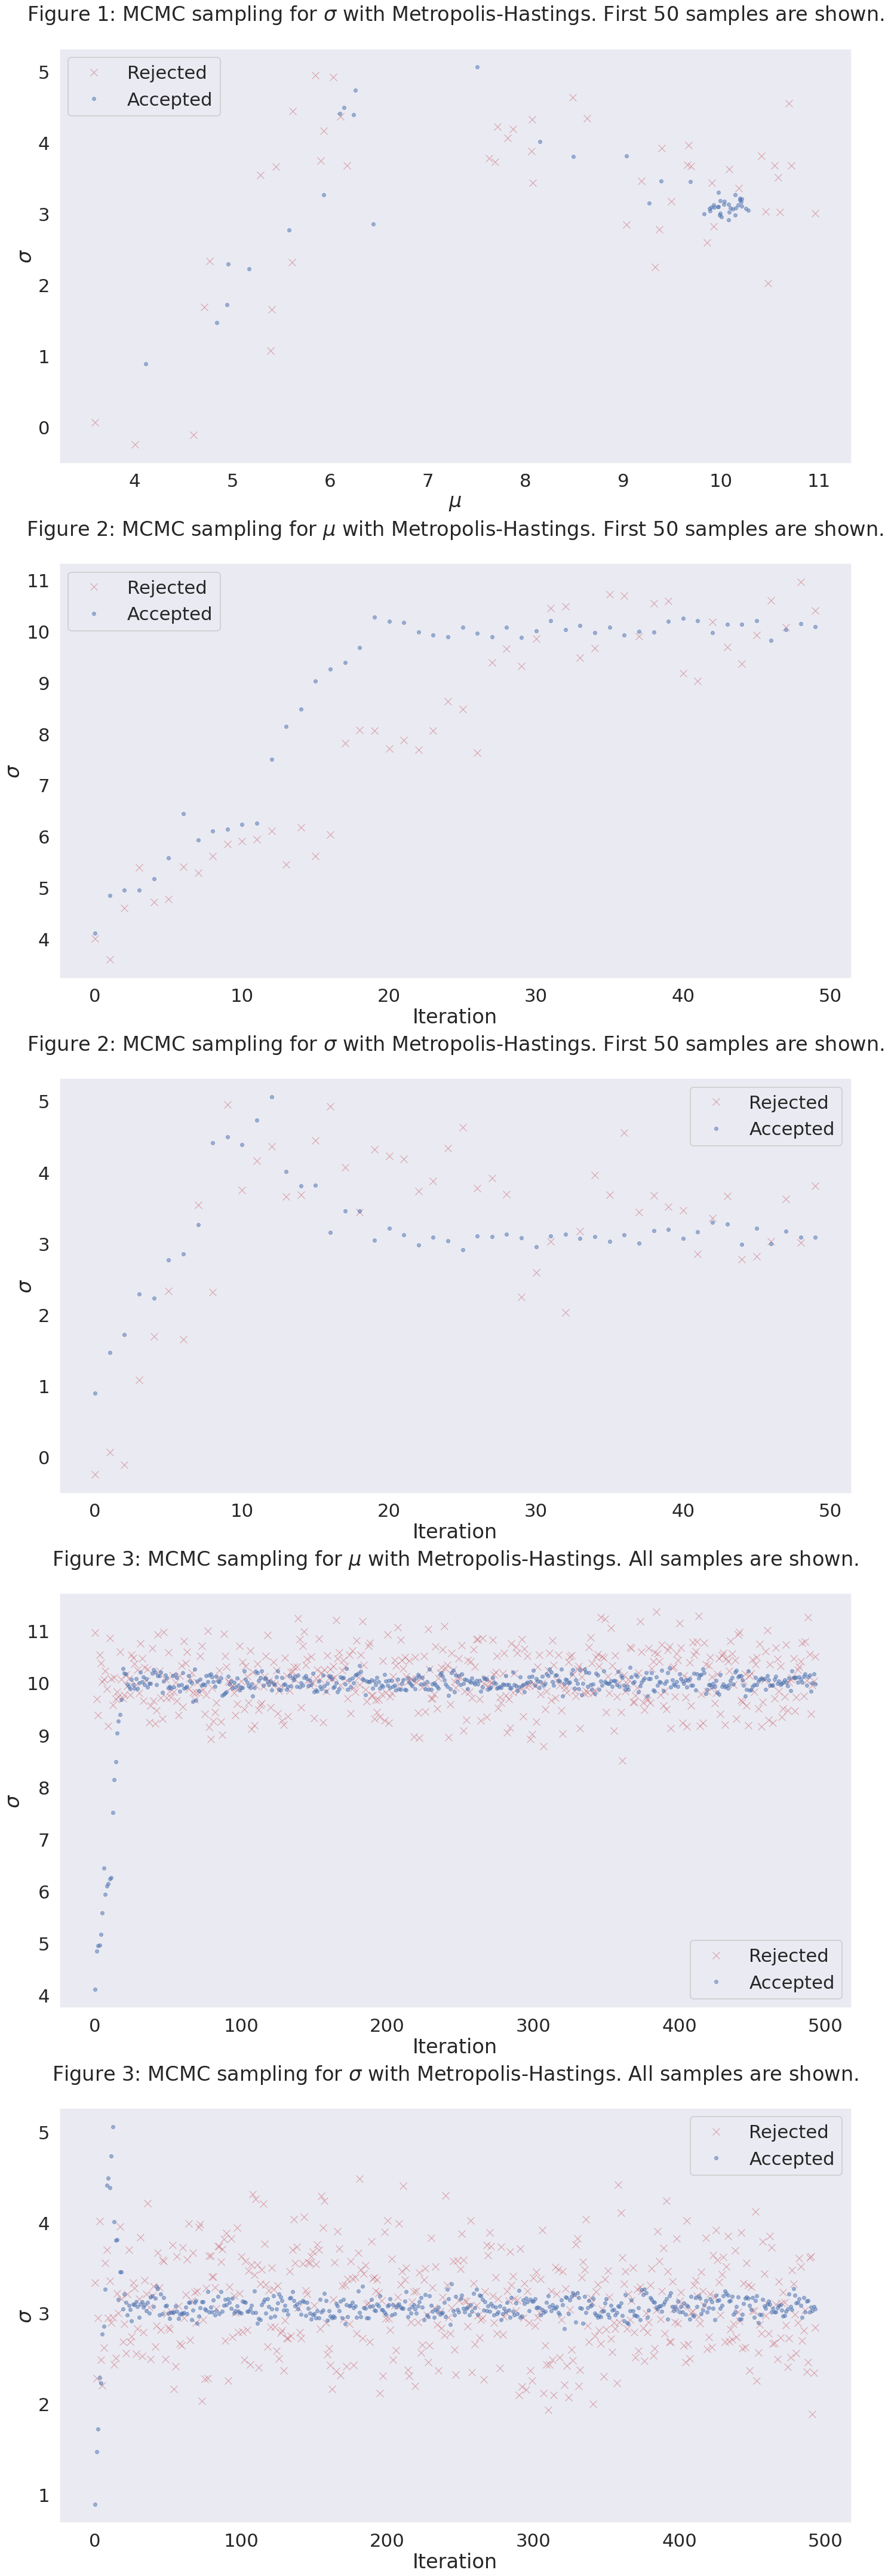

In [286]:
fig = plt.figure(figsize=(20,60))

ax0 = fig.add_subplot(5,1,1)
ax0.plot(rejected[0:50,0],rejected[0:50,1], 'rx', label='Rejected',alpha=0.5)
ax0.plot(accepted[0:50,0],accepted[0:50,1], 'b.', label='Accepted',alpha=0.5)
ax0.set_xlabel("$\mu$")
ax0.set_ylabel("$\sigma$")
ax0.set_title("Figure 1: MCMC sampling for $\sigma$ with Metropolis-Hastings. First 50 samples are shown.\n")
ax0.grid()
ax0.legend()

ax1 = fig.add_subplot(5,1,2)
ax1.plot(rejected[0:50,0], 'rx', label='Rejected',alpha=0.5)
ax1.plot(accepted[0:50,0], 'b.', label='Accepted',alpha=0.5)
ax1.set_xlabel("Iteration")
ax1.set_ylabel("$\sigma$")
ax1.set_title("Figure 2: MCMC sampling for $\mu$ with Metropolis-Hastings. First 50 samples are shown.\n")
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(5,1,3)
ax2.plot( rejected[0:50,1], 'rx', label='Rejected',alpha=0.5)
ax2.plot( accepted[0:50,1], 'b.', label='Accepted',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.set_title("Figure 2: MCMC sampling for $\sigma$ with Metropolis-Hastings. First 50 samples are shown.\n")
ax2.grid()
ax2.legend()

ax3 = fig.add_subplot(5,1,4)
to_show=-accepted.shape[0]
ax3.plot( rejected[to_show:,0], 'rx', label='Rejected',alpha=0.5)
ax3.plot( accepted[to_show:,0], 'b.', label='Accepted',alpha=0.5)
ax3.set_xlabel("Iteration")
ax3.set_ylabel("$\sigma$")
ax3.set_title("Figure 3: MCMC sampling for $\mu$ with Metropolis-Hastings. All samples are shown.\n")
ax3.grid()
ax3.legend()

ax4 = fig.add_subplot(5,1,5)
to_show=-accepted.shape[0]
ax4.plot( rejected[to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax4.plot( accepted[to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax4.set_xlabel("Iteration")
ax4.set_ylabel("$\sigma$")
ax4.set_title("Figure 3: MCMC sampling for $\sigma$ with Metropolis-Hastings. All samples are shown.\n")
ax4.grid()
ax4.legend()

fig.tight_layout()
plt.show()